In [185]:
import os                                             # Operational System para manipulação de arquivos.
import cv2                                            # OpenCV para manipulação de imagens.
import random
import numpy as np                                    # Numpy para manipulação de matrizes e arrays.
import matplotlib.pyplot as plt                       # Pyplot para plotagem de gráficos e imagens.
from sklearn.metrics import confusion_matrix          # Scikit-Learn para plotar a matriz de confusão

from tensorflow.keras import layers                   # Módulo de camadas do Keras
from tensorflow.keras import callbacks                # Módulo de callbacks do Keras
from tensorflow.keras import optimizers               # Módulo de otimizadores do Keras
from tensorflow.keras.models import load_model        # Função para carregar um modelo salvo
from tensorflow.keras.models import Sequential        # Classe de modelos sequenciais para construir as redes neurais.
from tensorflow.keras.applications import VGG16       # Classe de modelos sequenciais para construir as redes neurais.

from google_drive_downloader import GoogleDriveDownloader as gdd

# ImageDataGenerator, utilizado para carregar imagens em tempo de execução
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [186]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [187]:
!ls


drive  flagged	model2.h5  sample_data


In [188]:
val_datagen   = ImageDataGenerator( rescale = 1./255 )
val_generator = val_datagen.flow_from_directory("/content/drive/MyDrive/Chest Cancer Detection Resized/Data/validation resized", target_size = (250, 250),
                                                 batch_size  = 64)

Found 72 images belonging to 4 classes.


In [189]:
# Atributo do generator que fornece o número de amostras detectadas
val_samples = val_generator.samples 
print(val_samples, "amostras detectadas")

# Atributo do generator que fornece o mapeamento de classe para índice 
# Repare que os índices são definidos pelo generator com base nos diretórios de arquivos em ordem alfabética
class_to_idx_dict = val_generator.class_indices
print( "Mapeamento Classes -> Índices:", class_to_idx_dict )

# Construção de um novo dicionário que inverte o mapeamento
idx_to_class_dict = { v: k for k, v in class_to_idx_dict.items() }
print( "Mapeamento Índices -> Classes:", idx_to_class_dict )

72 amostras detectadas
Mapeamento Classes -> Índices: {'Resized adenocarcinoma': 0, 'Resized large.cell.carcinoma': 1, 'Resized normal': 2, 'Resized squamous.cell.carcinoma': 3}
Mapeamento Índices -> Classes: {0: 'Resized adenocarcinoma', 1: 'Resized large.cell.carcinoma', 2: 'Resized normal', 3: 'Resized squamous.cell.carcinoma'}


In [190]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,        # normalizando as imagens
    rotation_range = 20,       # Rotação aleatória de até 20°
    width_shift_range = 0.2,   # Translação horizontal de até 20% da largura
    height_shift_range = 0.2,  # Translação vertical de até 20% da altura
    #zoom_range = 0.2,          # Zoom aleatório de até 20%
    shear_range = 0.1,         # Deformação de 10%
    horizontal_flip = True,    # Espelhamento horizontal aleatório
    vertical_flip = False,     # Espelhamento vertical aleatório
    fill_mode = "nearest")     # Preenchimentod e buracos pelo pixel mais próximo

train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Chest Cancer Detection Resized/Data/train resized", target_size = (250, 250),
    batch_size  = 64)


# Atributo do generator que fornece o número de amostras detectadas
train_samples = train_generator.samples 
print(train_samples)

Found 601 images belonging to 4 classes.
601


In [191]:
test_datagen   = ImageDataGenerator( rescale = 1./255 )
test_generator = test_datagen.flow_from_directory("/content/drive/MyDrive/Chest Cancer Detection Resized/Data/test resized", target_size = (250, 250),
                                                   batch_size  = 64, shuffle = False)
batch_size = 10

Found 315 images belonging to 4 classes.


In [192]:
def print_vgg16_summary( shape ):
    conv_base = VGG16(include_top = False, weights = "imagenet", input_shape = shape)
    print( conv_base.summary() )
    return

print_vgg16_summary( shape = (250, 250, 3) )

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0     

In [193]:
def build_model( input_shape, n_outputs ):
    # Base convolucional
    conv_base = VGG16(include_top = False, weights = "imagenet", input_shape = input_shape)
    conv_base.trainable = False
    
    rede = Sequential()
    rede.add( conv_base )
    rede.add( layers.Flatten() )
    rede.add( layers.Dense( 256, activation = "relu" ) )
    rede.add( layers.Dense(   4, activation = "softmax" ) )
    
    return rede

model = build_model( (250, 250, 3), 1 )
model.compile(optimizer=optimizers.Adam(lr=1e-4), 
              loss="categorical_crossentropy", 
              metrics=["acc"])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_11 (Flatten)        (None, 25088)             0         
                                                                 
 dense_22 (Dense)            (None, 256)               6422784   
                                                                 
 dense_23 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 21,138,500
Trainable params: 6,423,812
Non-trainable params: 14,714,688
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [179]:
# definindo todas as camadas do modelo como treináveis 
model.trainable = True
# obtendo as camadas convolucionais da arquitetura VGG16
conv_base = model.get_layer("vgg16")

# criando uma flag de estado de treinamento e inicializando-a como falsa (estado não treinável) 
set_trainable = False
# para cada uma das camadas convolucionais da VGG16...
for layer in conv_base.layers:
    # se a camada for igual a 'block5_conv2'...
    if layer.name == "block4_conv1":
        # a flag de estado de treinamento muda de estado para estado treinável
        set_trainable = True
    # todas as camadas posteriores a 'block5_conv2' são configuradas como treinável 
    # e as camadas anteriores como não treináveis
    layer.trainable = set_trainable

In [180]:
conv_base = model.get_layer("vgg16")
for layer in conv_base.layers:
    status = "Treinável" if layer.trainable else "Congelada"
    print("Camada '{}' - Status: {} - Entrada: {} - Saída: {}".format(layer.name,
                                                                      status, 
                                                                      layer.input_shape, 
                                                                      layer.output_shape))

Camada 'input_22' - Status: Congelada - Entrada: [(None, 250, 250, 3)] - Saída: [(None, 250, 250, 3)]
Camada 'block1_conv1' - Status: Congelada - Entrada: (None, 250, 250, 3) - Saída: (None, 250, 250, 64)
Camada 'block1_conv2' - Status: Congelada - Entrada: (None, 250, 250, 64) - Saída: (None, 250, 250, 64)
Camada 'block1_pool' - Status: Congelada - Entrada: (None, 250, 250, 64) - Saída: (None, 125, 125, 64)
Camada 'block2_conv1' - Status: Congelada - Entrada: (None, 125, 125, 64) - Saída: (None, 125, 125, 128)
Camada 'block2_conv2' - Status: Congelada - Entrada: (None, 125, 125, 128) - Saída: (None, 125, 125, 128)
Camada 'block2_pool' - Status: Congelada - Entrada: (None, 125, 125, 128) - Saída: (None, 62, 62, 128)
Camada 'block3_conv1' - Status: Congelada - Entrada: (None, 62, 62, 128) - Saída: (None, 62, 62, 256)
Camada 'block3_conv2' - Status: Congelada - Entrada: (None, 62, 62, 256) - Saída: (None, 62, 62, 256)
Camada 'block3_conv3' - Status: Congelada - Entrada: (None, 62, 62, 25

In [194]:
model.compile(optimizer=optimizers.Adam(learning_rate = 1e-5), 
              loss = "categorical_crossentropy", 
              metrics = ["acc"])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_11 (Flatten)        (None, 25088)             0         
                                                                 
 dense_22 (Dense)            (None, 256)               6422784   
                                                                 
 dense_23 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 21,138,500
Trainable params: 6,423,812
Non-trainable params: 14,714,688
_________________________________________________________________


In [195]:
model_checkpoint = callbacks.ModelCheckpoint("model2.h5", monitor = "accuracy", save_best_only = True, verbose = 1)
reduce_lr_on_plateau = callbacks.ReduceLROnPlateau(monitor = "accuracy", factor = 0.75, patience = 3, verbose = 1)

# Repare que ao utilizar mais de 1 callback elas devem ser organizadas em uma lista
callback_list = [model_checkpoint, reduce_lr_on_plateau]

In [196]:
ACCURACY_THRESHOLD = 0.95

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]
callbacks = myCallback()
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=METRICS)

In [197]:
history=model.fit(train_generator,validation_data=val_generator,epochs = 1000,callbacks=[callbacks],verbose = 1)

Epoch 1/1000
10/10 [==============================] - 18s 2s/step - loss: 7.2339 - accuracy: 0.6780 - precision: 0.3340 - recall: 0.2895 - auc: 0.5663 - val_loss: 1.6113 - val_accuracy: 0.7396 - val_precision: 0.4516 - val_recall: 0.1944 - val_auc: 0.5998
Epoch 2/1000
10/10 [==============================] - 16s 2s/step - loss: 1.5156 - accuracy: 0.7537 - precision: 0.5115 - recall: 0.3328 - auc: 0.6765 - val_loss: 1.3176 - val_accuracy: 0.7292 - val_precision: 0.4559 - val_recall: 0.4306 - val_auc: 0.7359
Epoch 3/1000
10/10 [==============================] - 16s 2s/step - loss: 0.9938 - accuracy: 0.7908 - precision: 0.6690 - recall: 0.3228 - auc: 0.8165 - val_loss: 0.9068 - val_accuracy: 0.7951 - val_precision: 0.6383 - val_recall: 0.4167 - val_auc: 0.8422
Epoch 4/1000
10/10 [==============================] - 16s 2s/step - loss: 0.8657 - accuracy: 0.8103 - precision: 0.7409 - recall: 0.3710 - auc: 0.8651 - val_loss: 0.8485 - val_accuracy: 0.8160 - val_precision: 0.8276 - val_recall: 0

In [ ]:
history = model.fit( train_generator, steps_per_epoch = (len(train_generator)/batch_size),
                     epochs = 1000, callbacks = callback_list, 
                     validation_data = val_generator, validation_steps = 10)

model.load_weights("model2.h5")

history_dict = history.history

In [202]:
test_datagen   = ImageDataGenerator( rescale = 1./255 )
test_generator = test_datagen.flow_from_directory("/content/drive/MyDrive/Chest Cancer Detection Resized/Data/test resized", target_size = (250, 250),
                                                   batch_size  = 64, shuffle = False)

# Atributo do generator que fornece o número de amostras detectadas
test_samples = test_generator.samples

test_loss, accuracy,_,_,_ = model.evaluate( test_generator )

print("Test Accuracy:", 100*accuracy, "%")
print("Acertos: {} - Erros: {}".format(round(test_samples * accuracy), 
                                       round(test_samples * (1-accuracy) )))

Found 315 images belonging to 4 classes.
5/5 [==============================] - 4s 695ms/step - loss: 0.3330 - accuracy: 0.9421 - precision: 0.8878 - recall: 0.8794 - auc: 0.9810
Test Accuracy: 94.20635104179382 %
Acertos: 297 - Erros: 18


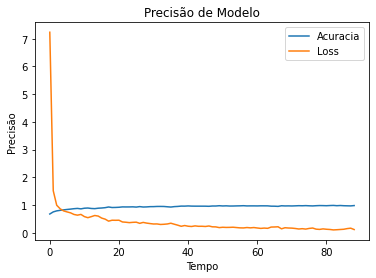

In [204]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Precisão de Modelo')
plt.ylabel('Precisão')
plt.xlabel('Tempo')
plt.legend(['Acuracia', 'Loss'], loc = 0)
plt.show()

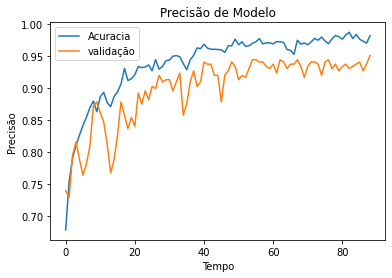

In [207]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisão de Modelo')
plt.ylabel('Precisão')
plt.xlabel('Tempo')
plt.legend(['Acuracia', 'validação'], loc = 0)
plt.show()

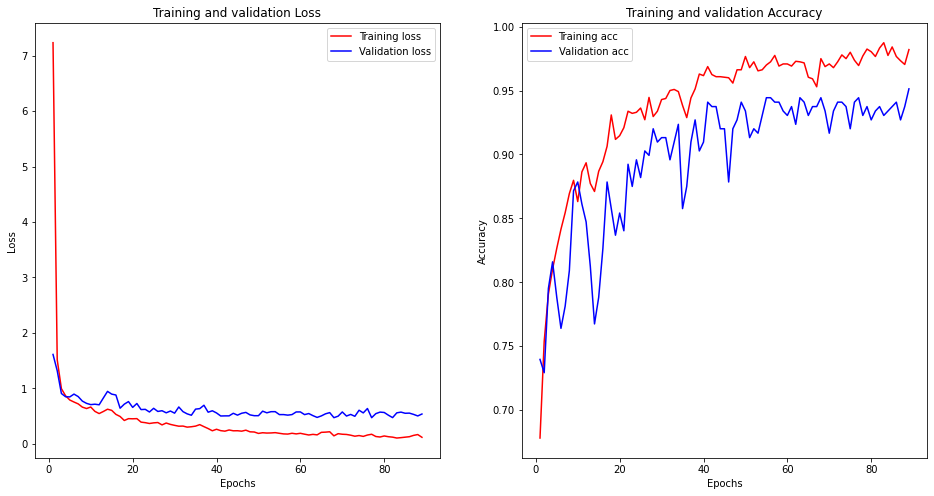

In [209]:
fig, axes = plt.subplots(1, 2, squeeze = False, figsize = (16,8))

# Loss
train_loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]

# Epochs
epochs = range(1, len(train_loss_values) + 1)

# Accuracy
train_acc_values = history.history["accuracy"]
val_acc_values = history.history["val_accuracy"]

ax = axes.flat[0]
ax.plot(epochs, train_loss_values, "r", label="Training loss")
ax.plot(epochs, val_loss_values, "b", label="Validation loss")
ax.set_title("Training and validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()

ax = axes.flat[1]
ax.plot(epochs, train_acc_values, "r", label="Training acc")
ax.plot(epochs, val_acc_values, "b", label="Validation acc")
ax.set_title("Training and validation Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()